In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

torch.cuda.set_device(0)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Data

### Setup

In [5]:
PATH = Path('/fastai/data/carvana/')
list(PATH.iterdir())

[PosixPath('/fastai/data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('/fastai/data/carvana/metadata.csv.zip'),
 PosixPath('/fastai/data/carvana/sample_submission.csv.zip'),
 PosixPath('/fastai/data/carvana/test.zip'),
 PosixPath('/fastai/data/carvana/train_hq.zip'),
 PosixPath('/fastai/data/carvana/train_masks.csv.zip'),
 PosixPath('/fastai/data/carvana/train_masks.zip'),
 PosixPath('/fastai/data/carvana/train.zip'),
 PosixPath('/fastai/data/carvana/metadata.csv'),
 PosixPath('/fastai/data/carvana/sample_submission.csv'),
 PosixPath('/fastai/data/carvana/test_hq'),
 PosixPath('/fastai/data/carvana/test'),
 PosixPath('/fastai/data/carvana/train_masks.csv'),
 PosixPath('/fastai/data/carvana/train_masks'),
 PosixPath('/fastai/data/carvana/train'),
 PosixPath('/fastai/data/carvana/train_masks_png'),
 PosixPath('/fastai/data/carvana/train-128'),
 PosixPath('/fastai/data/carvana/train_masks-128'),
 PosixPath('/fastai/data/carvana/tmp'),
 PosixPath('/fastai/data/carvana/models')]

In [6]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [7]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [8]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [9]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [10]:
CAR_ID = '00087a6bd4dc'

In [11]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('/fastai/data/carvana/train/00087a6bd4dc_01.jpg'),
 PosixPath('/fastai/data/carvana/train/00087a6bd4dc_02.jpg'),
 PosixPath('/fastai/data/carvana/train/00087a6bd4dc_03.jpg'),
 PosixPath('/fastai/data/carvana/train/00087a6bd4dc_04.jpg'),
 PosixPath('/fastai/data/carvana/train/00087a6bd4dc_05.jpg')]

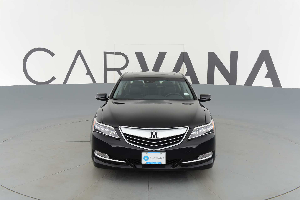

In [12]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [13]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('/fastai/data/carvana/train_masks/00087a6bd4dc_01_mask.gif'),
 PosixPath('/fastai/data/carvana/train_masks/00087a6bd4dc_02_mask.gif'),
 PosixPath('/fastai/data/carvana/train_masks/00087a6bd4dc_03_mask.gif'),
 PosixPath('/fastai/data/carvana/train_masks/00087a6bd4dc_04_mask.gif'),
 PosixPath('/fastai/data/carvana/train_masks/00087a6bd4dc_05_mask.gif')]

In [14]:
list((PATH/MASKS_DN).iterdir())[:1][0].name, list((PATH/MASKS_DN).iterdir())[:1][0].name[:-4]

('00087a6bd4dc_01_mask.gif', '00087a6bd4dc_01_mask')

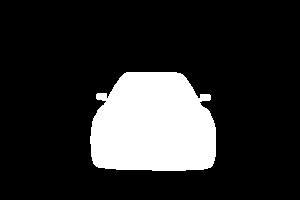

In [15]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

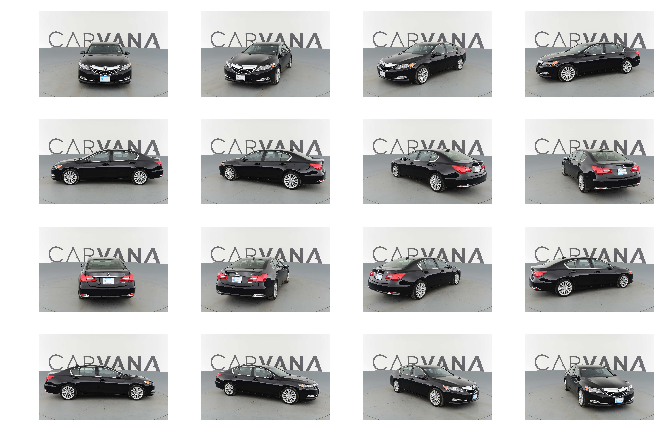

In [16]:
ims = [open_image(str(PATH/TRAIN_DN) + f'/{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
fig,axes = plt.subplots(4,4, figsize=(9,6))
for i,ax in enumerate(axes.flat): show_img(ims[i],ax=ax)
plt.tight_layout(pad=0.1)

## Resize and convert

In [22]:
(PATH/'train_masks_png').mkdir()

In [17]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/MASKS_DN/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')# take jpg and save as png

In [18]:
files = list((PATH/MASKS_DN).iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [45]:
(PATH/'train_masks-128').mkdir()

In [19]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save(PATH/'train_masks-128'/fn.name)
    
files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [40]:
(PATH/'train-128').mkdir()

In [20]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save(PATH/'train-128'/fn.name)
    
files = list((PATH/TRAIN_DN).iterdir())
%time with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

CPU times: user 5min 36s, sys: 1.62 s, total: 5min 38s
Wall time: 42.7 s


## Dataset

In [21]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs =64

In [22]:
ims = [open_image(str(PATH/TRAIN_DN)+ f'/{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(str(PATH/MASKS_DN) +f'/{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

In [23]:
im_masks[0], im_masks[0].shape

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32), (128, 128, 3))

In [24]:
im_masks[0][...,0], im_masks[0][...,0].shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), (128, 128))

In [25]:
im_masks[0][...,2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

`im_masks` is a tensor array of masks each 128,128 size and 3 channels RGB colors. So
`im_masks[i]` is one such mask 
`im_masks[i][...,0]` takes all dimensions preceding and 0th element in the last dimention so in this case 128,128 and just 1st color, if we used `im_masks[i][...,1]` it would be the middle color in RGB

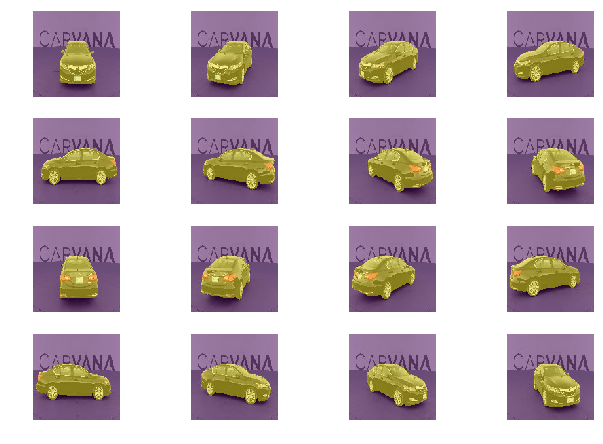

In [26]:
fig, axes = plt.subplots(4,4, figsize=(9,6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i],ax=ax)
    show_img(im_masks[i][...,0],ax=ax,alpha=0.5)
plt.tight_layout(pad=0.1)

In [27]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames,transform,path)
    def get_y(self,i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [28]:
Path(TRAIN_DN)

PosixPath('train-128')

In [29]:
x_names = np.array([str(Path(TRAIN_DN)/o) for o in masks_csv['img']])
y_names = np.array([str(Path(MASKS_DN))+f'/{o[:-4]}_mask.png' for o in masks_csv['img']])

In [30]:
len(x_names)//16//5*16

1008

In [31]:
val_idxs = list(range(1008))
((val_x,trn_x), (val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x), len(trn_x)

(1008, 4080)

In [32]:
aug_tfms = [ RandomRotate(4, tfm_y= TfmType.CLASS),
             RandomFlip(tfm_y=TfmType.CLASS),
             RandomLighting(0.05, 0.05)]

In [33]:
tfms =  tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y= TfmType.CLASS, aug_tfms=aug_tfms)
datasets =  ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=str(PATH))
md = ImageData(str(PATH), datasets, bs, num_workers=8, classes=None)

In [34]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))

In [35]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

Y does not have the color channels and so does not need to be normalized or denormalized

In [36]:
x = denorm(x)

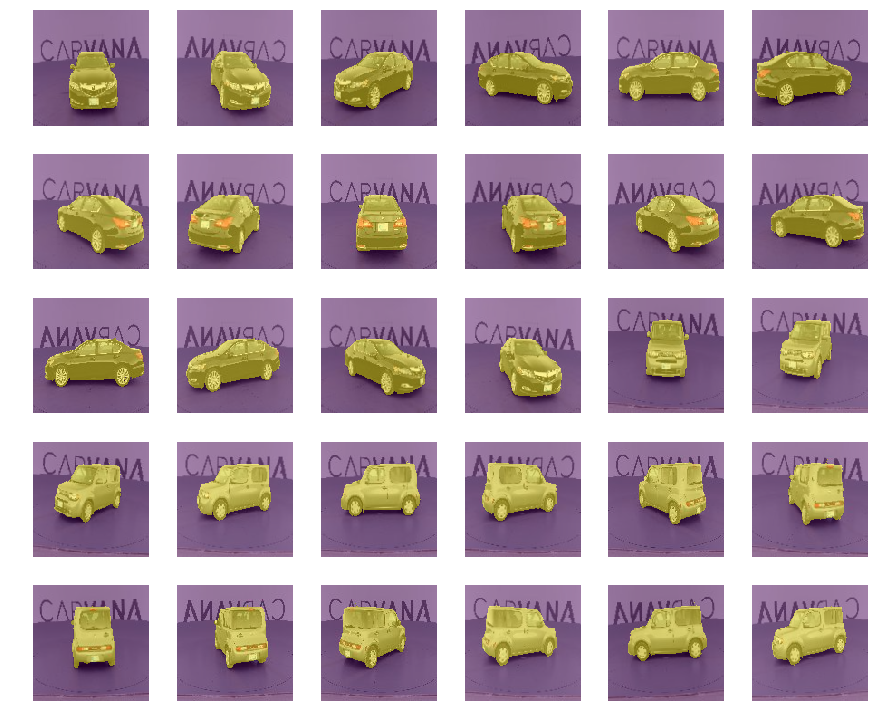

In [37]:
fig, axes = plt.subplots(5,6, figsize=(12,10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [38]:
class Empty(nn.Module):
    def forward(self, x): return x
    
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 27353796.49it/s]


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 

An Empty layer is added to resnet34

In [39]:
class StdUpSample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [40]:
flatten_channel =  Lambda(lambda x: x[:, 0])

In [41]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpSample(512,256),
    StdUpSample(256,256),
    StdUpSample(256,256),
    StdUpSample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [42]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up )
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit =  nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5)]

 89%|████████▉ | 57/64 [00:09<00:01,  5.86it/s, loss=1.25] 


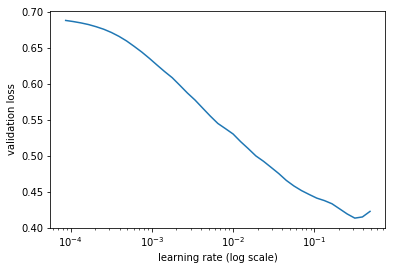

In [43]:
learn.lr_find()
learn.sched.plot()

In [44]:
lr=4e-2

In [45]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.178448   0.156513   0.939197  
    1      0.126396   0.117358   0.942068                  
    2      0.104554   0.100709   0.956958                  
    3      0.092674   0.093251   0.958846                   
    4      0.08424    0.08776    0.959772                   



[0.08776005251067025, 0.9597724449066889]

In [46]:
learn.save('tmp')

In [47]:
learn.load('tmp')

In [48]:
py, ay = learn.predict_with_targs()

In [49]:
py.shape, ay.shape

((1008, 128, 128), (1008, 128, 128))

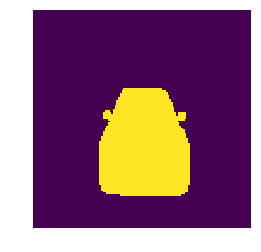

In [50]:
show_img(ay[0])

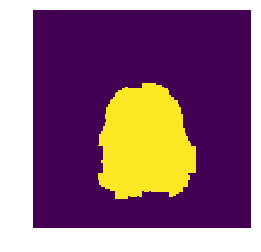

In [51]:
show_img(py[0]>0)

In [52]:
learn.unfreeze()

In [53]:
learn.bn_freeze(True)

In [54]:
lrs = np.array([lr/100, lr/10, lr])/4

In [55]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.068862   0.058229   0.977686  
    1      0.050515   0.044281   0.980995                   
    2      0.039559   0.035746   0.984351                   
    3      0.03328    0.030427   0.986308                   
    4      0.030019   0.031533   0.985283                   
    5      0.090461   0.505613   0.836712                   
    6      0.298526   0.260079   0.869161                  
    7      0.249118   0.190441   0.921969                  
    8      0.153838   0.083959   0.963745                  
    9      0.0935     0.06207    0.974387                   
    10     0.065954   0.053612   0.978718                   
    11     0.053691   0.046698   0.979233                   
    12     0.04723    0.044448   0.979782                   
    13     0.043614   0.041666   0.981008                   
    14     0.041428   0.041105   0.983052                   
    15     0.038992   0.039507   0.983785   

[0.03583825450567972, 0.9847792368086558]

In [56]:
learn.save('0')

In [57]:
x,y = next(iter(md.val_dl))

In [58]:
py = to_np(learn.model(V(x)))

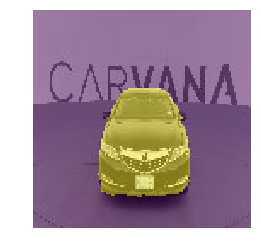

In [59]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5)

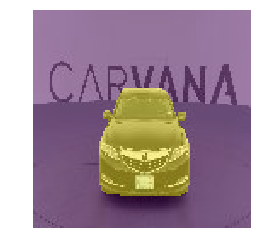

In [60]:
ax= show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5)

## 512x512

In [79]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16

In [80]:
x_names = np.array([str(Path(TRAIN_DN)/o) for o in masks_csv['img']])
y_names = np.array([str(Path(MASKS_DN))+f'/{o[:-4]}_mask.png' for o in masks_csv['img']])

In [81]:
((val_x,trn_x), (val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x), len(trn_x)

(1008, 4080)

In [82]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y= TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=str(PATH))
md = ImageData(str(PATH), datasets, bs, num_workers=8, classes=None)

In [83]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [84]:
x.shape, y.shape

((16, 512, 512, 3), torch.Size([16, 512, 512]))

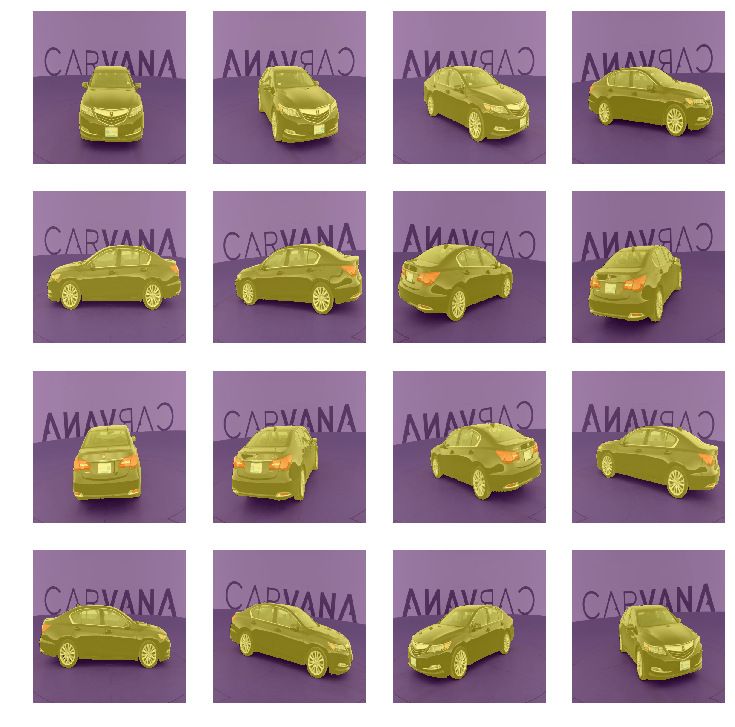

In [86]:
fig, axes = plt.subplots(4,4, figsize=(10,10))
for i,ax in enumerate(axes.flat):
    ax= show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [87]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpSample(512,256),
    StdUpSample(256,256),
    StdUpSample(256,256),
    StdUpSample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [88]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [89]:
learn.load('0')

In [70]:
# t = torch.load(learn.get_model_path('0'), map_location=lambda storage, loc: storage)
# learn.model.load_state_dict(t, strict=False)

since the image is now resized we load with state_dict strict=False to allow for torch to fill in values missing

 77%|███████▋  | 197/255 [03:42<01:05,  1.13s/it, loss=0.425]

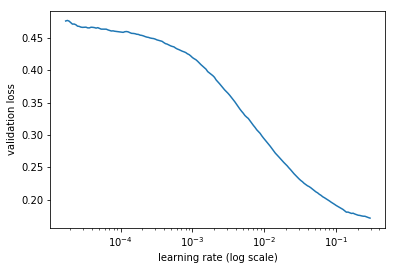

In [90]:
learn.lr_find()
learn.sched.plot()

In [91]:
lr=4e-2

In [92]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.078594   0.083297   0.971676  
    1      0.061709   0.079053   0.972946                     
    2      0.054133   0.049283   0.978999                     
    3      0.048789   0.045964   0.981605                     
    4      0.045732   0.042223   0.98259                      


[0.04222307472474991, 0.9825899411761572]

In [93]:
learn.save('tmp')

In [98]:
learn.load('tmp')

In [99]:
learn.unfreeze()
learn.bn_freeze(True)

In [100]:
lrs = np.array([lr/100,lr/10,lr])/4

In [101]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.059157   0.028573   0.989257  
    1      0.017555   0.016679   0.993741                     
    2      6074.39628 15.471107  0.705891                       
    3      35.875581  0.498883   0.794132                      
    4      0.54492    0.26803    0.862076                    
    5      0.209078   0.152838   0.935838                    
    6      0.124846   0.106667   0.953112                    
    7      0.170734   0.138444   0.938826                    
    8      0.10363    0.090898   0.961221                    
    9      0.088481   0.08124    0.965724                     
    10     0.08129    0.079014   0.967457                     
    11     0.074016   0.072988   0.970365                     
    12     0.07091    0.06898    0.972323                     
    13     0.067168   0.062014   0.973338                     
    14     0.062034   0.062231   0.974553                     
    15     0.

[0.053450979233261135, 0.9773329515305776]

In [102]:
learn.save('512')

In [103]:
learn.load('512')

In [104]:
learn.unfreeze()
learn.bn_freeze(True)

In [105]:
lrs = np.array([lr/100,lr/10,lr])/8

In [106]:
learn.fit(lrs, 1, cycle_len=10, use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.053599   0.059749   0.976153  
    1      0.057438   0.052834   0.978996                     
    2      0.038825   0.035693   0.98446                      
    3      0.031313   0.031796   0.986957                     
    4      0.027236   0.028274   0.988592                     
    5      0.024736   0.025831   0.988283                     
    6      0.023107   0.023531   0.98963                      
    7      0.021618   0.022298   0.990983                     
    8      0.020613   0.021314   0.991114                     
    9      0.019943   0.021057   0.99112                      


[0.02105682904994677, 0.9911204784635513]

In [107]:
learn.save('512-1')

In [108]:
learn.load('512-1')

In [109]:
learn.unfreeze()
learn.bn_freeze(True)

In [112]:
lrs = np.array([lr/1000, lr/100, lr/10])/4

In [113]:
learn.fit(lrs, 1, cycle_len=10, cycle_mult=2, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.020206   0.021675   0.990699  
    1      0.019882   0.020677   0.99153                      
    2      0.01943    0.02021    0.991506                     
    3      0.018734   0.019722   0.991535                     
    4      0.018671   0.019927   0.992122                     
    5      0.018192   0.019285   0.992218                     
    6      0.017972   0.019224   0.991983                     
    7      0.017938   0.018714   0.992034                     
    8      0.017622   0.01869    0.99222                      
    9      0.017431   0.018529   0.992425                     


[0.018529231793114116, 0.992424798390222]

In [114]:
learn.save('512-2')

In [115]:
learn.load('512-1')

In [116]:
learn.unfreeze()
learn.bn_freeze(True)

In [117]:
lrs = np.array([lr/100,lr/10,lr])/4

In [118]:
learn.fit(lrs, 1, cycle_len=8, use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                     
    0      0.112956   0.061733   0.974668  
    1      0.047607   0.034072   0.984895                     
    2      0.026349   0.026677   0.989562                     
    3      0.021583   0.022004   0.99124                      
    4      0.019738   0.020206   0.99181                      
    5      0.018148   0.018697   0.992224                     
    6      0.017217   0.018213   0.993                        
    7      0.016554   0.017391   0.993143                     


[0.017390558244808327, 0.9931430816650391]

In [119]:
learn.save('512-3')

In [120]:
learn.load('512-3')

## 1024x1024

In [155]:
sz = 1024
bs = 4

In [156]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y),tfms, path=str(PATH))
md = ImageData(str(PATH), datasets, bs, num_workers=8, classes=None)

In [157]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

In [159]:
y.shape, x.shape

((4, 1024, 1024), (4, 1024, 1024, 3))

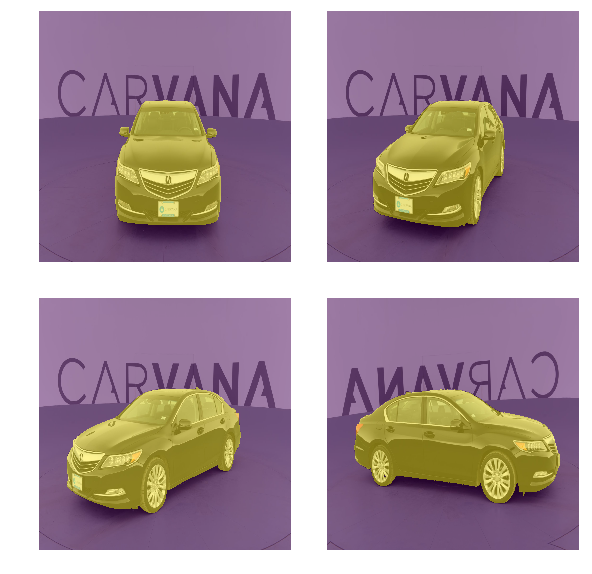

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [161]:
simple_up =  nn.Sequential(
    nn.ReLU(),
    StdUpSample(512,256),
    StdUpSample(256,256),
    StdUpSample(256,256),
    StdUpSample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [162]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5)]

In [163]:
learn.load('512-3')

 84%|████████▎ | 852/1020 [07:31<01:29,  1.89it/s, loss=0.23]  

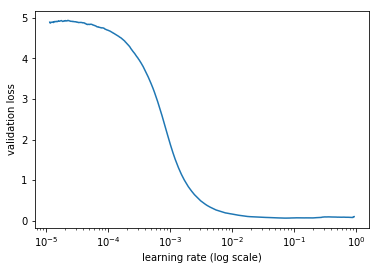

In [133]:
learn.lr_find()
learn.sched.plot()

In [164]:
lr=4e-2

In [135]:
learn.fit(lr, 1, cycle_len=2, use_clr=(20,4))

epoch      trn_loss   val_loss   <lambda>                       
    0      0.047371   0.04663    0.981507  
    1      0.038141   0.049904   0.984289                       


[0.049904148238489314, 0.9842887937076508]

In [136]:
learn.save('tmp-1')

In [165]:
learn.load('tmp-1')

In [166]:
learn.unfreeze()
learn.bn_freeze(True)

In [167]:
lrs = np.array([lr/1000, lr/100, lr/10])/4

In [168]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                       
    0      0.022976   1337166.649629 0.991203  
    1      0.050976   0.045634   0.980309                        
    2      0.031226   0.031865   0.987603                       
    3      0.025063   0.025248   0.989535                       
    4      0.021787   0.024051   0.989319                       
    5      0.023406   21800.207095 0.990972                     
    6      400.338582 0.050992   0.97847                         
    7      0.051986   0.046001   0.981378                        
    8      0.040971   0.038301   0.983662                       
    9      0.034361   0.033311   0.985914                       
    10     0.029849   0.029623   0.987592                       
    11     0.030268   0.027947   0.988498                       
    12     0.025921   0.025581   0.989326                       
    13     0.025951   0.024366   0.989825                       
    14     0.024331   0.023412   0.9900

[0.021317043474742343, 0.9914501763525463]

In [169]:
learn.save('1024-1')

In [170]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [171]:
py[0].shape

(1024, 1024)

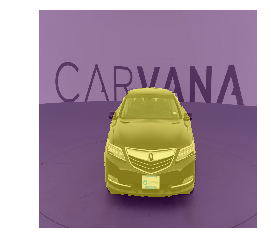

In [172]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5)

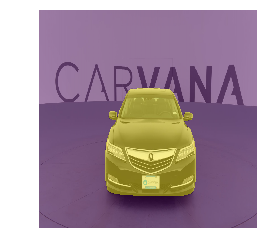

In [173]:
ax = show_img(denorm(x)[0])
show_img(y[0,...], ax=ax, alpha=0.5)

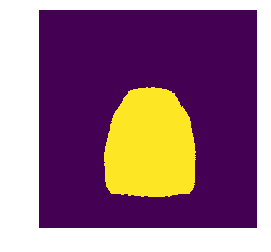

In [174]:
show_img(py[0]>0)

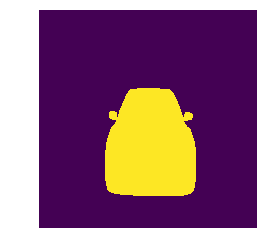

In [175]:
show_img(y[0,...])

In [177]:
learn.load('1024-1')

In [178]:
learn.unfreeze()
learn.bn_freeze(True)

In [179]:
lrs = np.array([lr/1000, lr/100, lr/10])/8

In [180]:
learn.fit(lrs, 1, cycle_len= 40, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                       
    0      0.020158   0.019836   0.991973  
    1      0.018642   0.019458   0.99275                        
    2      0.026116   0.024753   0.989999                       
    3      0.024417   0.024228   0.990244                       
    4      0.018232   0.019608   0.992814                       
    5      0.016342   0.017823   0.993631                       
    6      0.043413   0.038598   0.984624                       
    7      0.101089   0.044367   0.98338                       
    8      0.027838   0.028134   0.988469                       
    9      0.026199   0.026251   0.98904                        
    10     0.024604   0.023562   0.989956                       
    11     0.02327    0.022808   0.991012                       
    12     0.020705   0.021274   0.991739                       
    13     0.019569   0.019933   0.991956                       
    14     0.018628   0.019398   0.992501      

[0.01236303920473253, 0.995063044722118]

In [181]:
learn.save('1024-2')

In [182]:
learn.load('1024-2')

In [183]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

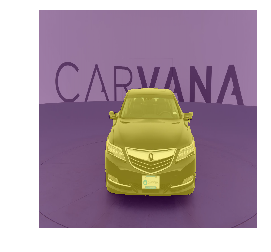

In [184]:
ax= show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5)

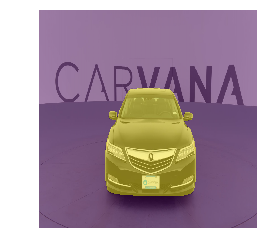

In [185]:
ax = show_img(denorm(x)[0])
show_img(y[0,...], ax=ax, alpha=0.5)

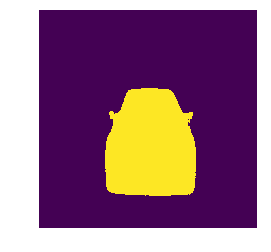

In [186]:
show_img(py[0]>0)

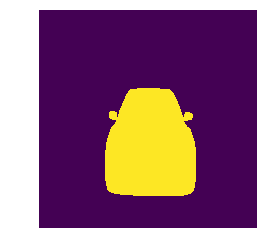

In [187]:
show_img(y[0,...])

In [190]:
lr=4e-2

In [191]:
learn.unfreeze()
learn.bn_freeze(True)

In [193]:
lrs = np.array([lr/1000,lr/100,lr/10])/16

In [194]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                       
    0      0.011547   0.012109   0.995109  
    1      0.011483   0.012011   0.995192                       
    2      0.012126   0.01288    0.994941                       
    3      0.011249   0.012432   0.995316                       
    4      0.010958   0.011979   0.995329                       
    5      0.010988   0.020193   0.994555                       
    6      0.014546   0.015242   0.99434                        
    7      0.012648   0.013672   0.994565                       
    8      0.01235    0.013036   0.994838                       
    9      0.011324   0.012692   0.995067                       
    10     0.011225   0.012449   0.99501                        
    11     0.011783   0.012313   0.995218                       
    12     0.011341   0.012199   0.995199                       
    13     0.010827   0.012001   0.995239                       
    14     0.011284   0.011885   0.995359     

[0.011660966752392669, 0.9954725693142603]

In [195]:
learn.save('1024-3')

In [196]:
learn.load('1024-3')

In [197]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

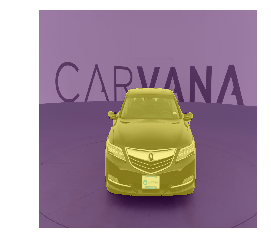

In [199]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5)

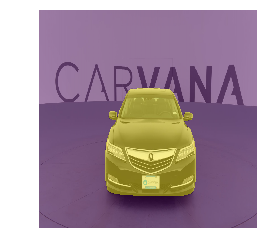

In [200]:
ax = show_img(denorm(x)[0])
show_img(y[0,...], ax=ax, alpha=0.5)

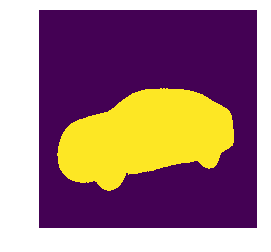

In [211]:
show_img(py[3]>0)

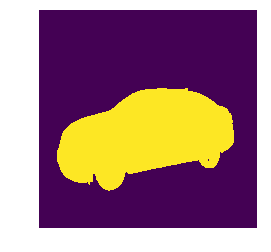

In [209]:
show_img(y[3,...])

In [212]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 1024, 1024]),
                           ('output_shape', [-1, 64, 512, 512]),
                           ('trainable', True),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 512, 512]),
                           ('output_shape', [-1, 64, 512, 512]),
                           ('trainable', True),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 512, 512]),
                           ('output_shape', [-1, 64, 512, 512]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 512, 512]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_sha

## Fin